In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-03 00:45:05.725707: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-03 00:45:05.750387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 00:45:05.776809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 00:45:05.776963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17457213145915247428
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5394006016
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1776035975854740942
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./reformattedData_20220531/All_cases_100x100_per500_zoom.hdf5', mode='r')
dataset = h5.get('phi')

# # Split into train and validation sets using indexing to optimize memory.
data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])
print(train_index)
print(val_index)

[ 2  3  4  5  6  7  9 10 11 12 14 16 17 18 19 22 23 24 26 27 28 30 31 32
 33 35 36 37 38 40 42 43 44 45 46 48 49 51 52 53 55 56 57 58 59 61 65 66
 67 68 69 70 71 72 73 74 75 78 79 80 81 82]
[ 0  1  8 13 15 20 21 25 29 34 39 41 47 50 54 60 62 63 64 76 77]


In [4]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

dataset.shape

(83, 70, 100, 100, 1)

In [5]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x, y

def create_shifted_frames_3to1(data):
    x1 = np.expand_dims(data[:, 0 : data.shape[1] - 3, :, :, 0],4)
    x2 = np.expand_dims(data[:, 1 : data.shape[1] - 2, :, :, 0],4)
    x3 = np.expand_dims(data[:, 2 : data.shape[1] - 1, :, :, 0],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = data[:, 3 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x,y

# Apply the processing function to the datasets.
# x_train, y_train = create_shifted_frames(train_dataset)
# x_val, y_val = create_shifted_frames(val_dataset)
x_train, y_train = create_shifted_frames_3to1(train_dataset)
x_val, y_val = create_shifted_frames_3to1(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (62, 67, 100, 100, 3), (62, 67, 100, 100, 1)
Validation Dataset Shapes: (21, 67, 100, 100, 3), (21, 67, 100, 100, 1)


Displaying frames for example 39.


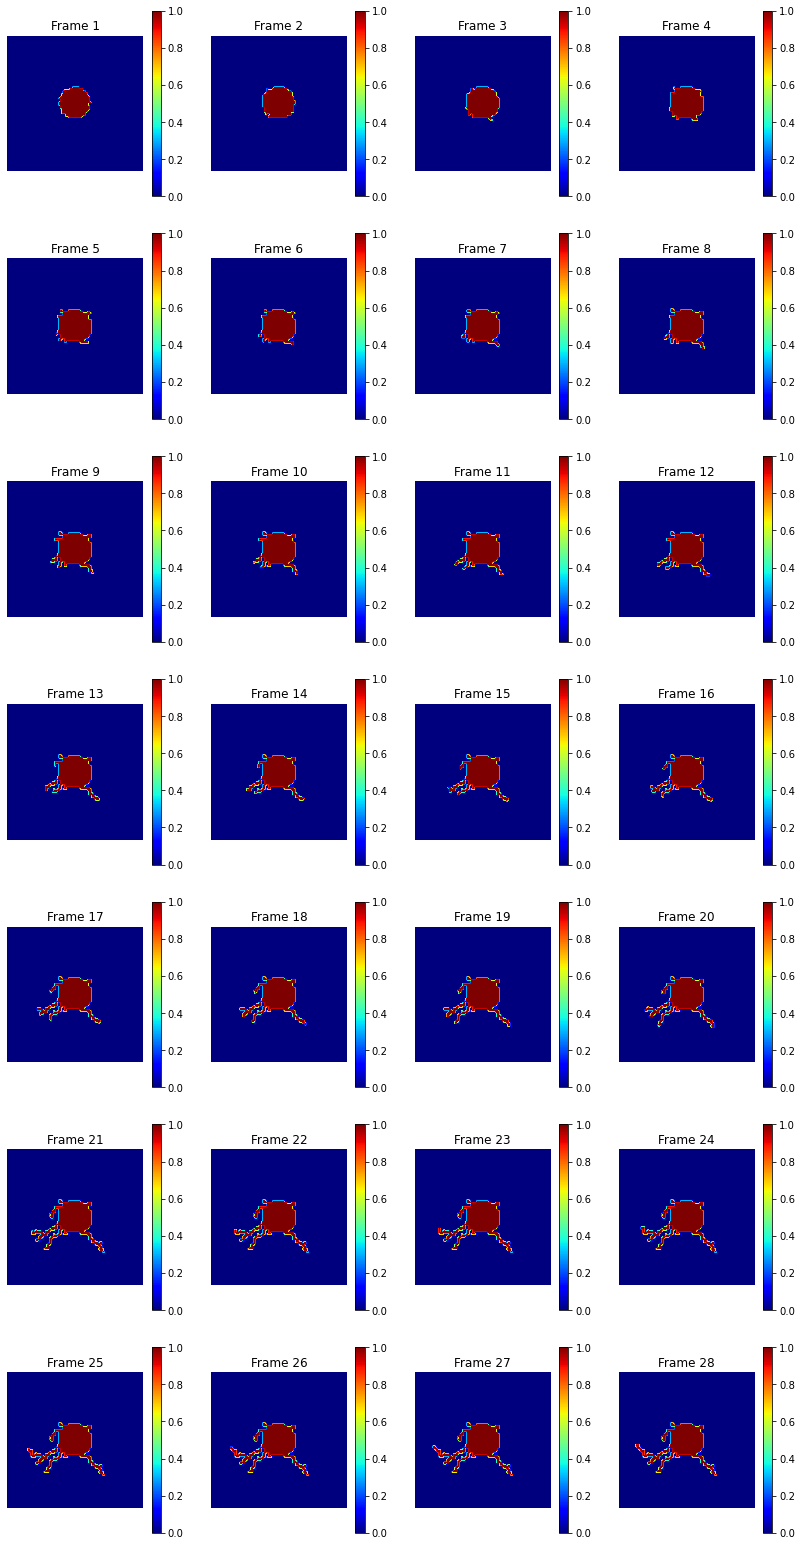

In [6]:
# Construct a figure on which we will visualize the images.
# fig, axes = plt.subplots(7, 4, figsize=(14, 28))
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(x_train)), size=1)[0]
fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(x_train[data_choice][idx][:,:,0]), cmap="jet")
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

Displaying frames for example 39.


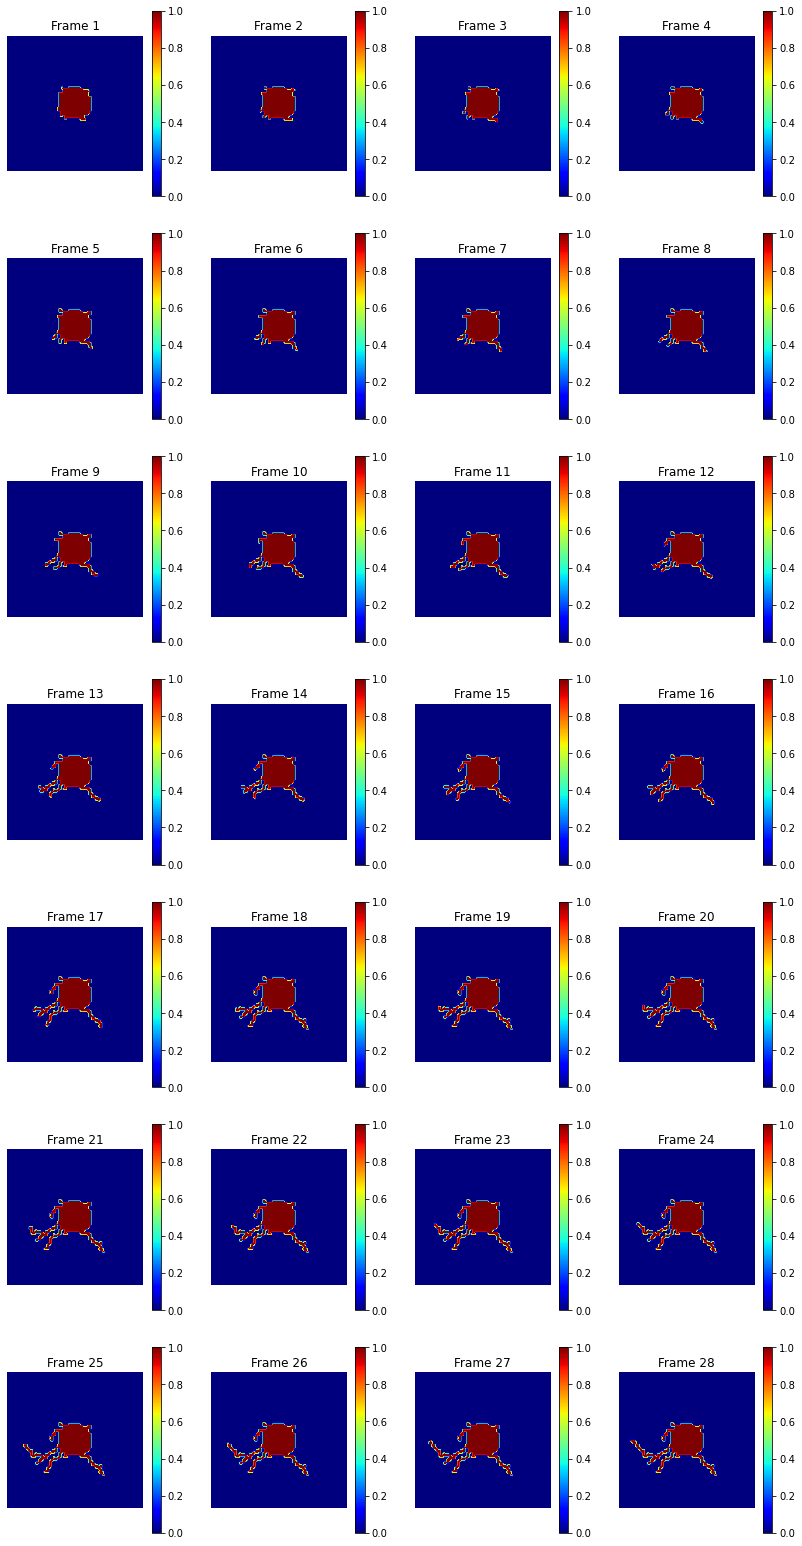

In [7]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(y_train[data_choice][idx][:,:,0]), cmap="jet")
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [8]:
# # Construct the input layer with no definite frame size.
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# x0 = layers.TimeDistributed(layers.Conv2D(
#     filters=64,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(inp)
# x1 = layers.TimeDistributed(layers.Conv2D(
#     filters=128,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x0)
# x2 = layers.ConvLSTM2D(
#     filters=128,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x1)
# x3 = layers.Concatenate(axis=4)([x1,x2])
# x4 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=64,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x3)
# x5 = layers.Concatenate(axis=4)([x0,x4])
# x6 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x5)
# # x6 = keras.backend.k_round(x6)

In [9]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x0 = layers.TimeDistributed(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x1 = layers.TimeDistributed(layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x1)
x3 = layers.Concatenate(axis=4)([x1,x2])
x4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x3)
x5 = layers.Concatenate(axis=4)([x0,x4])
x6 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(x5)
# out = layers.Lambda(lambda a: a[0] + a[1])([keras.backend.expand_dims(inp[...,2],axis=-1), x6])

2022-06-03 00:45:20.039179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 00:45:20.039348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 00:45:20.039448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 00:45:20.039675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 00:45:20.039784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
model = keras.models.Model(inp, x6)
model.compile(
    # loss=keras.losses.BinaryCrossentropy(reduction="auto", name="binary_crossentropy"),
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    # loss=keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 3)]                                                          
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 48, 48  4864       ['input_1[0][0]']                
 ted)                           , 64)                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, None, 22, 22  204928     ['time_distributed[0][0]']       
 buted)                         , 128)                                                        

In [11]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 500
batch_size = 1

# with tf.device('/device:CPU:0'):
with tf.device('/device:GPU:0'):
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_lr],
    )

Epoch 1/500


2022-06-03 00:45:22.380042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_189/input/_551' -> 'gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_189/gradient_tape/model/conv_lstm2d/while/gradients/AddN', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/convolution_6' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_4', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/clip_by_value' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_3', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/clip_by_value_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_5'}.
2022-06-03 00

62/62 [==============================] - ETA: 0s - loss: 0.2481

2022-06-03 00:45:38.456864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/Relu_1' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/convolution_7' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_6'}.


62/62 [==============================] - 18s 254ms/step - loss: 0.2481 - val_loss: 0.2440 - lr: 1.0000e-05
Epoch 2/500
62/62 [==============================] - 15s 248ms/step - loss: 0.2386 - val_loss: 0.2329 - lr: 1.0000e-05
Epoch 3/500
62/62 [==============================] - 15s 246ms/step - loss: 0.2347 - val_loss: 0.2374 - lr: 1.0000e-05
Epoch 4/500
62/62 [==============================] - 15s 245ms/step - loss: 0.2350 - val_loss: 0.2322 - lr: 1.0000e-05
Epoch 5/500
62/62 [==============================] - 15s 247ms/step - loss: 0.2293 - val_loss: 0.2260 - lr: 1.0000e-05
Epoch 6/500
62/62 [==============================] - 15s 247ms/step - loss: 0.2228 - val_loss: 0.2192 - lr: 1.0000e-05
Epoch 7/500
62/62 [==============================] - 15s 245ms/step - loss: 0.2157 - val_loss: 0.2119 - lr: 1.0000e-05
Epoch 8/500
62/62 [==============================] - 15s 246ms/step - loss: 0.2082 - val_loss: 0.2044 - lr: 1.0000e-05
Epoch 9/500
62/62 [==============================] - 15s 245

In [12]:
model.save('./tmp/model_conv_lstm_5')

2022-06-03 02:07:48.357208: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./tmp/model_conv_lstm_5/assets


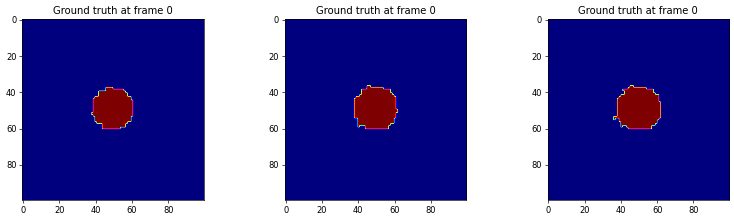

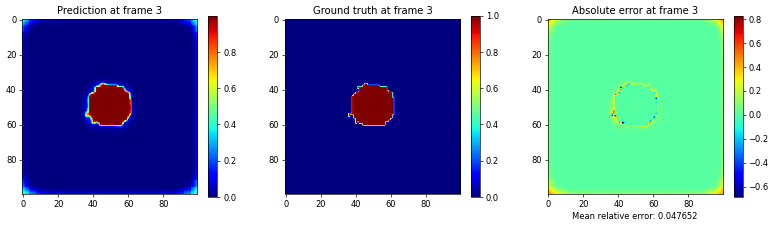

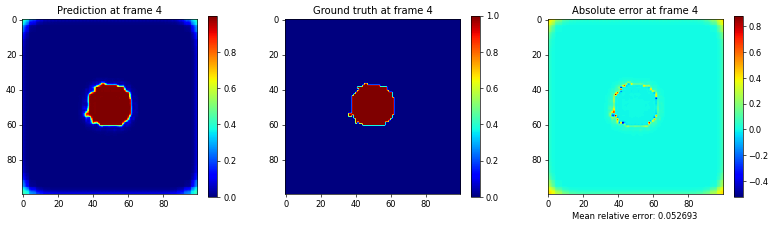

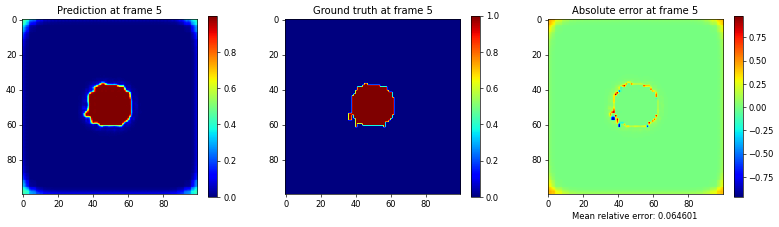

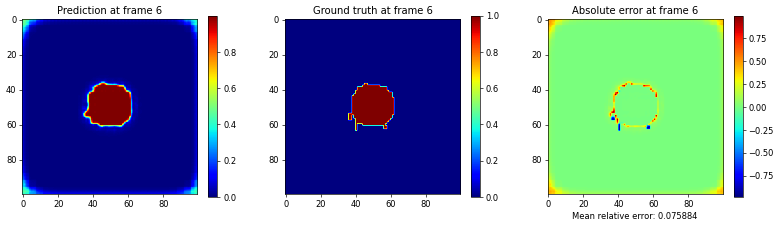

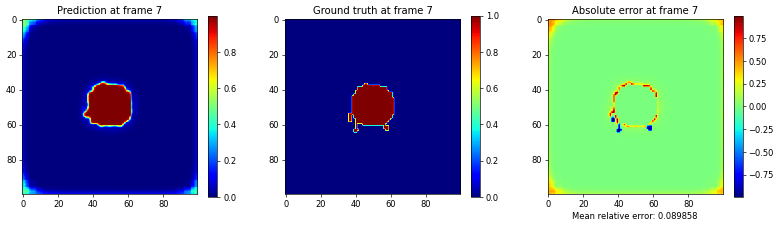

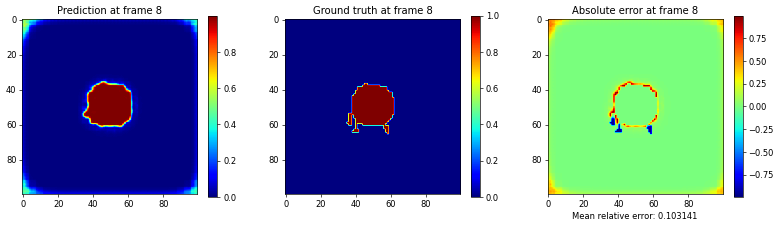

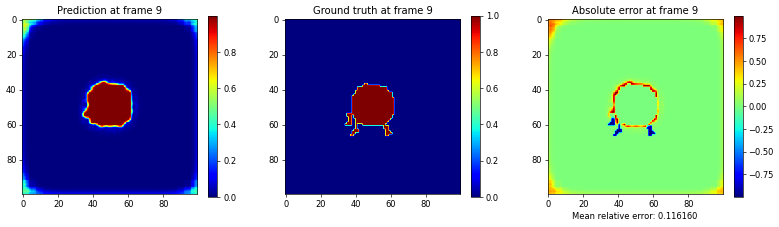

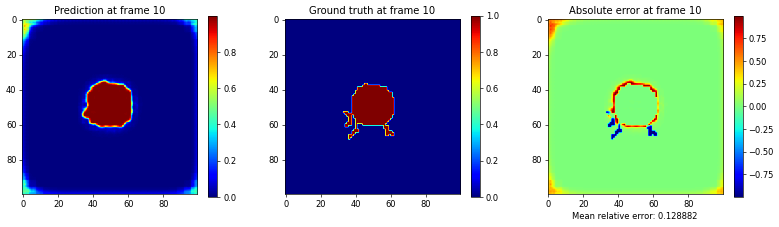

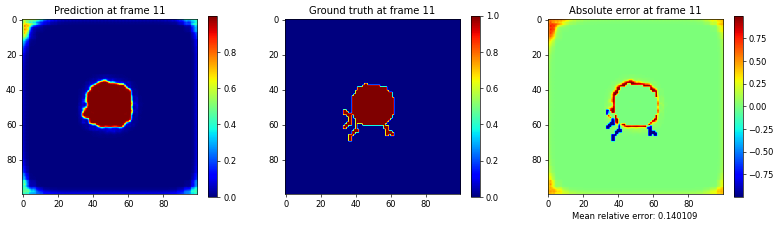

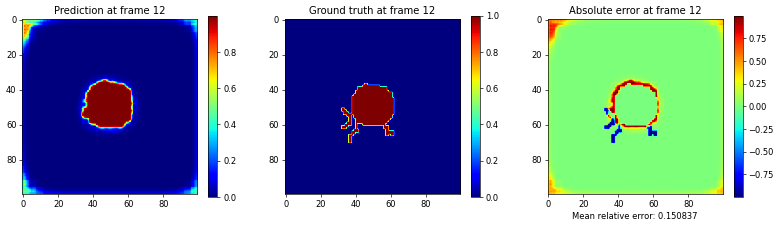

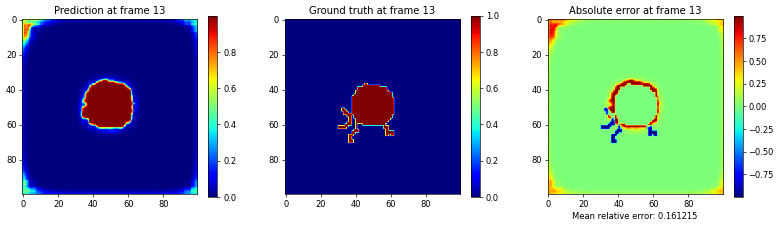

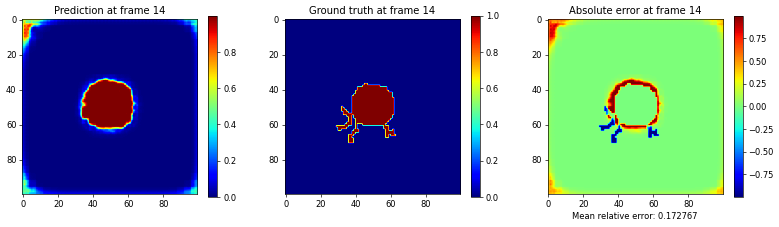

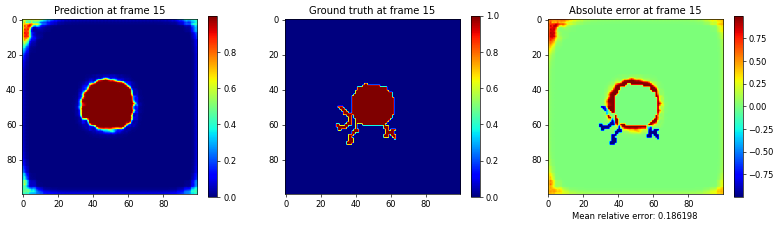

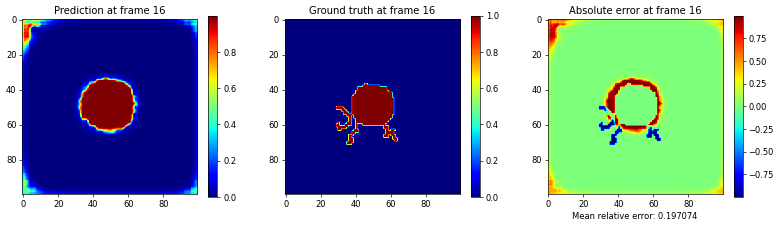

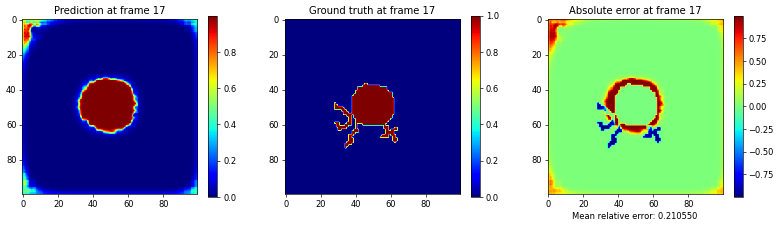

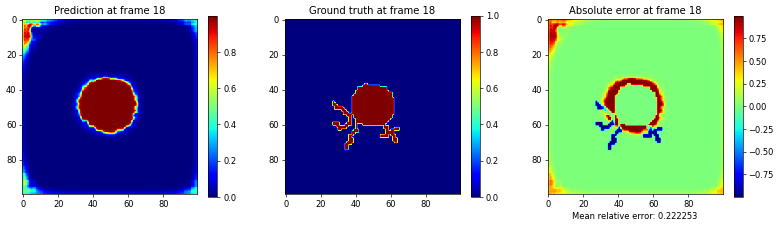

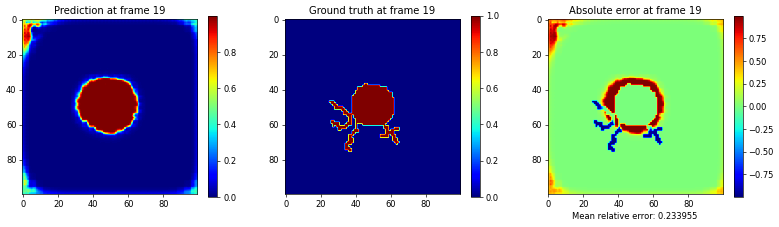

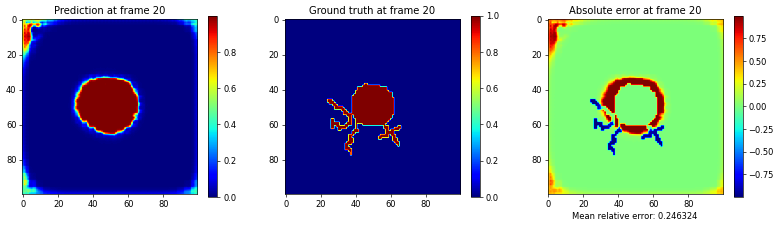

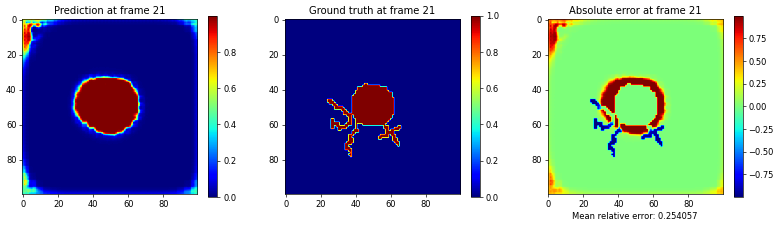

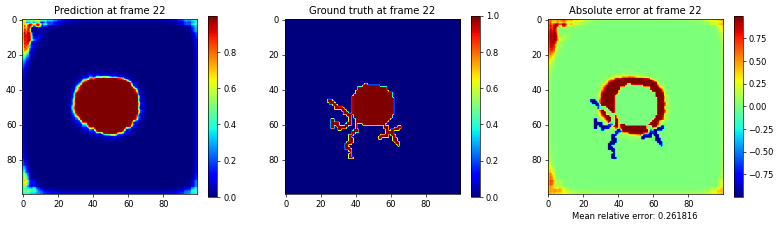

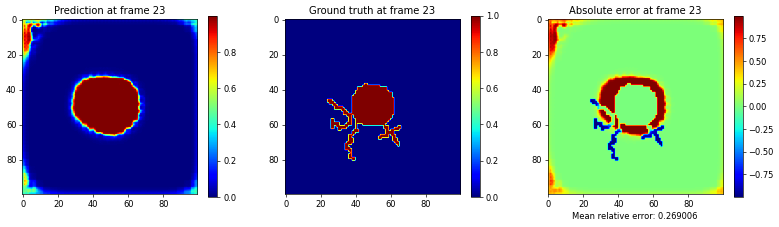

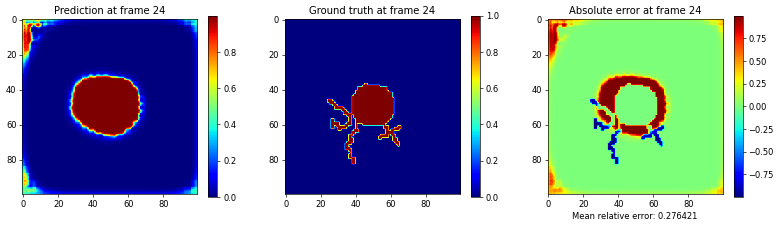

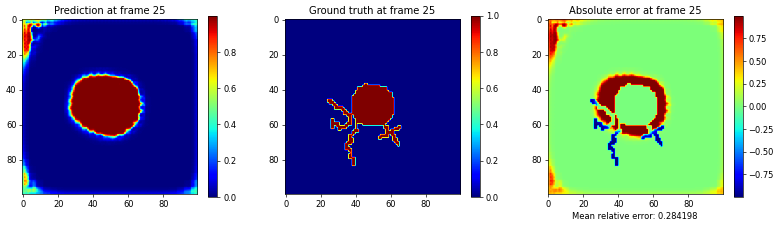

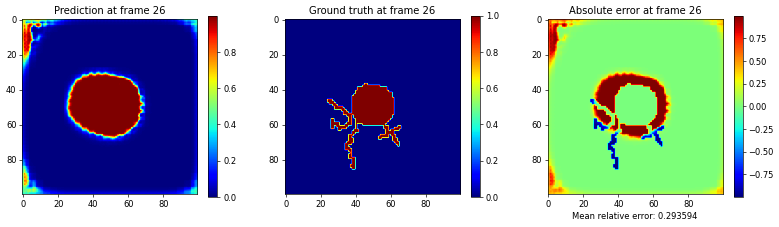

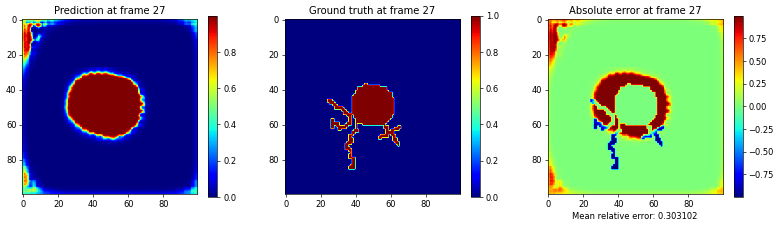

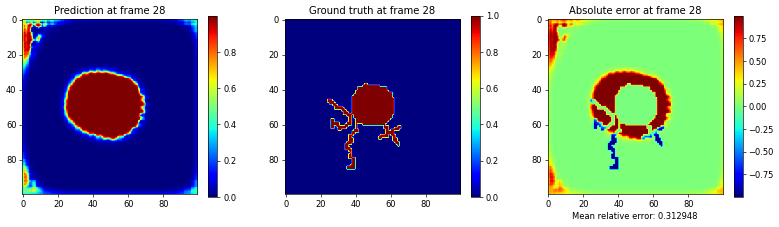

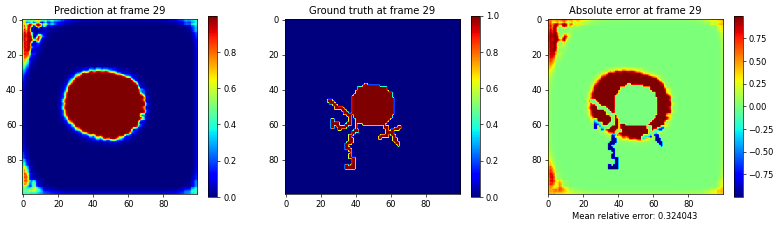

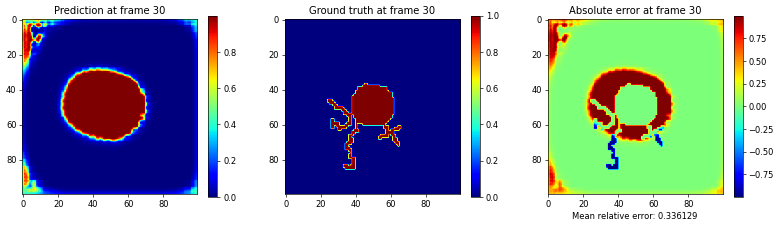

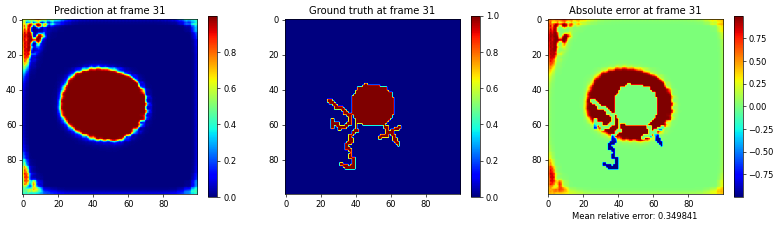

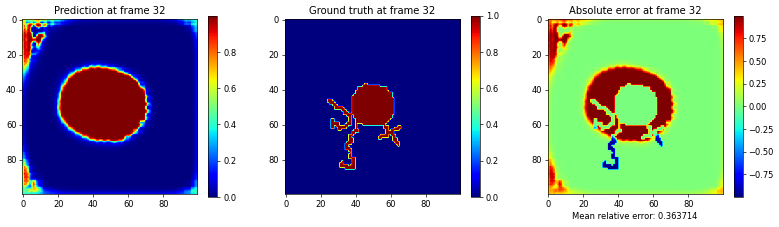

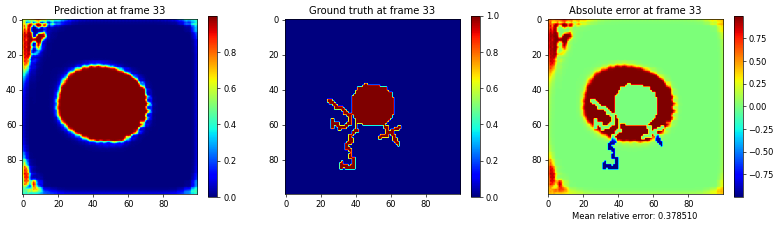

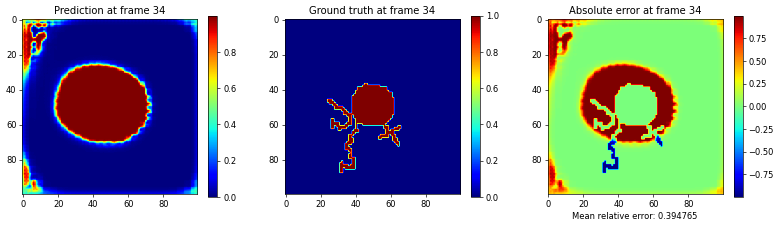

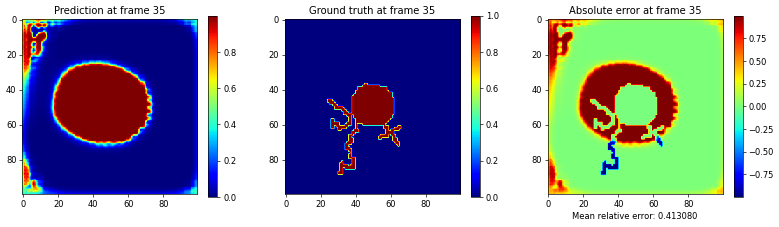

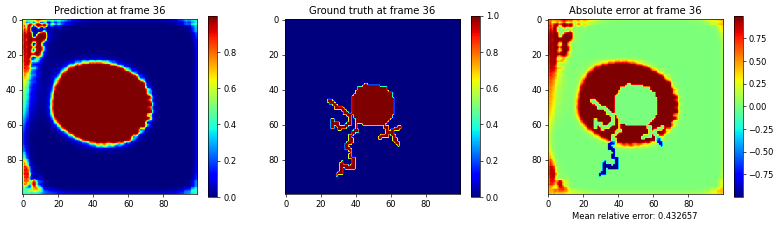

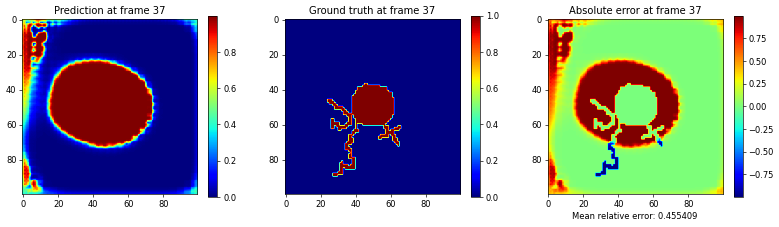

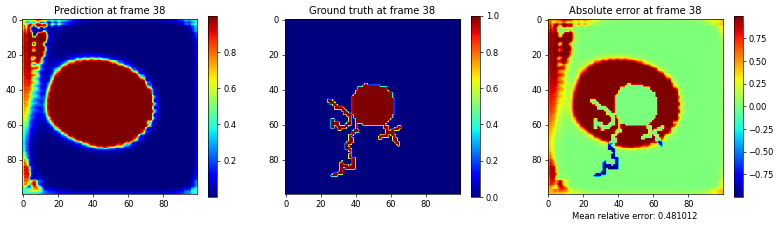

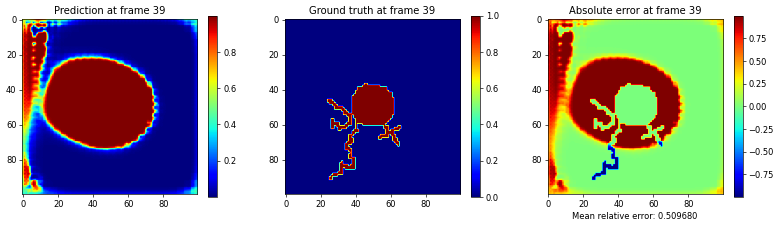

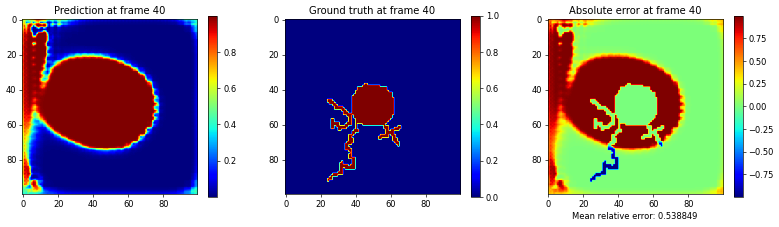

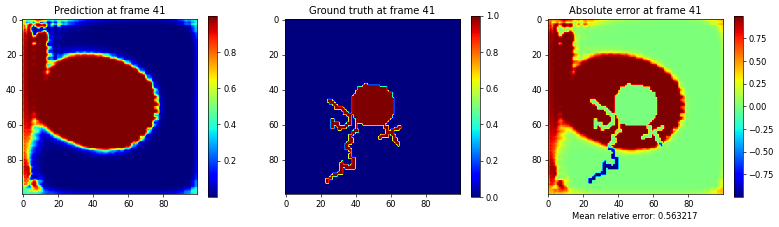

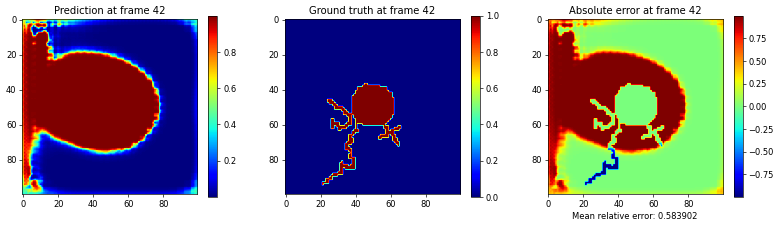

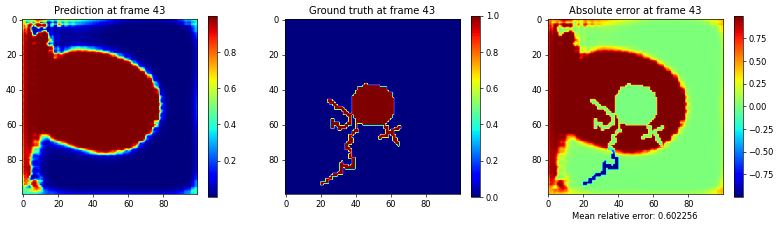

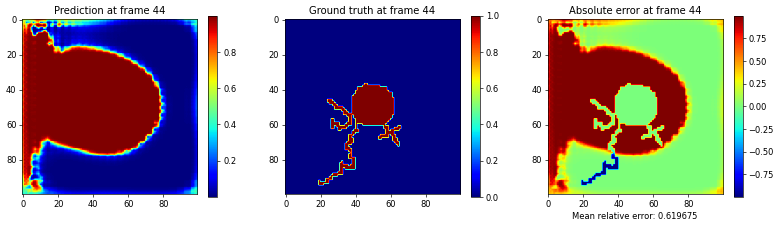

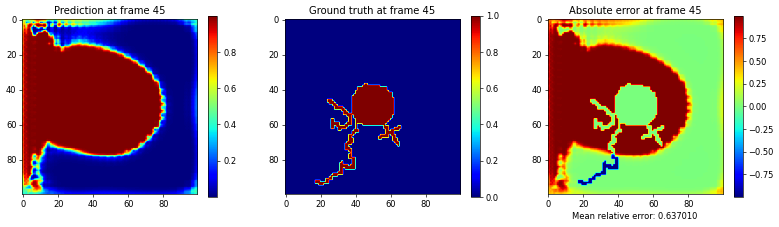

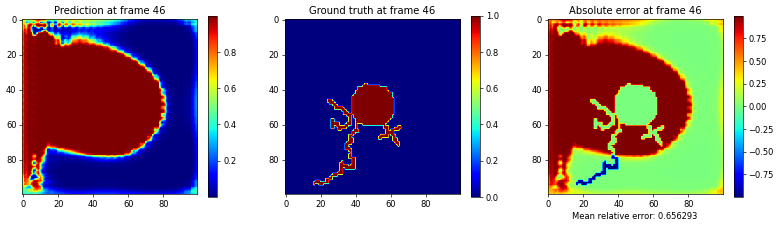

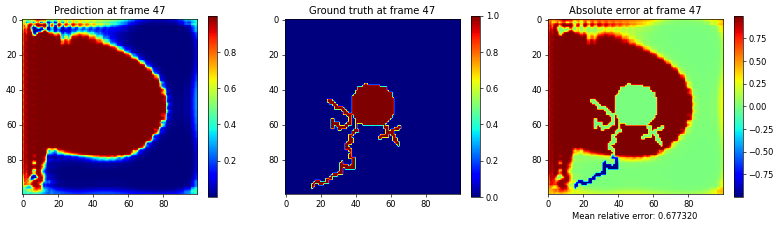

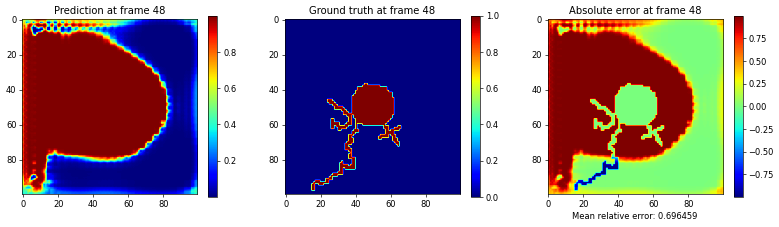

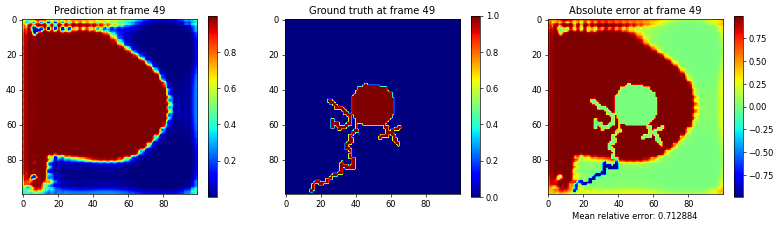

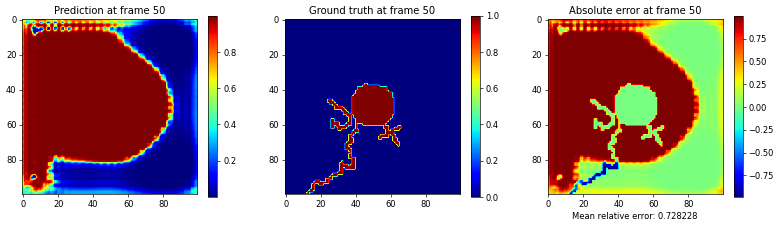

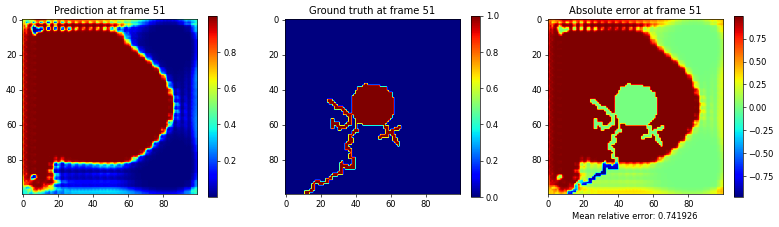

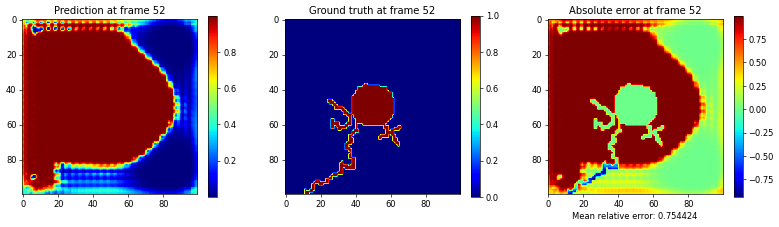

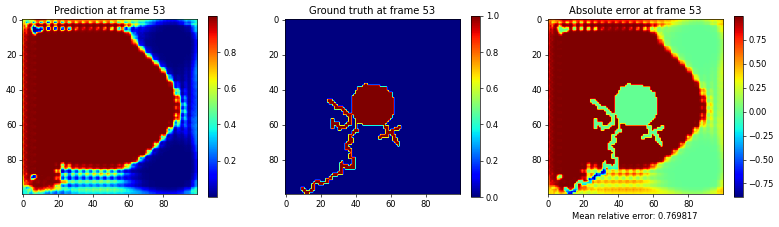

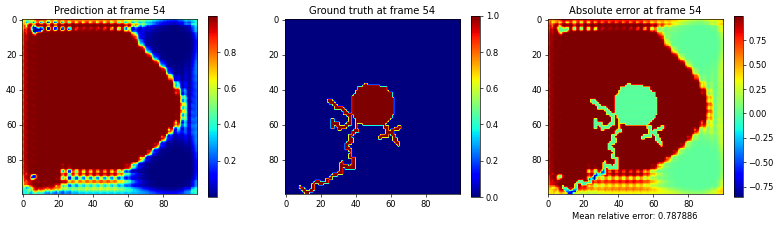

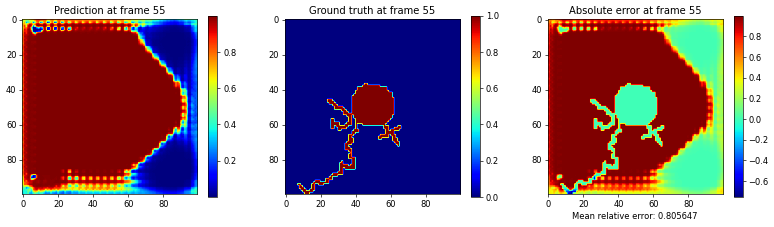

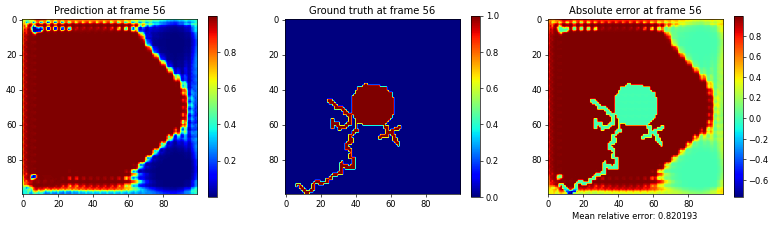

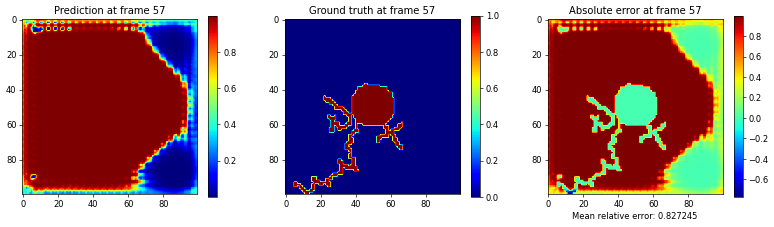

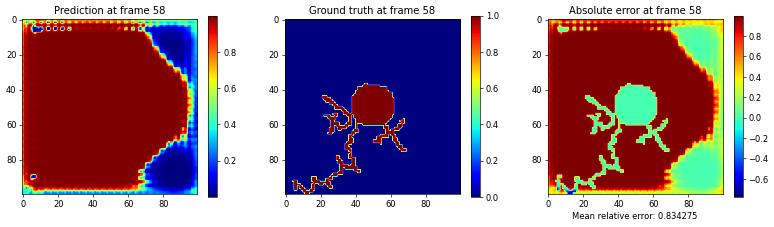

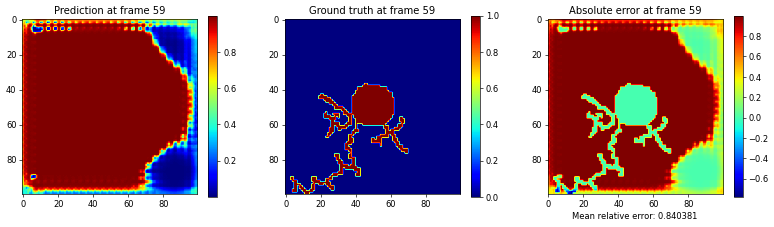

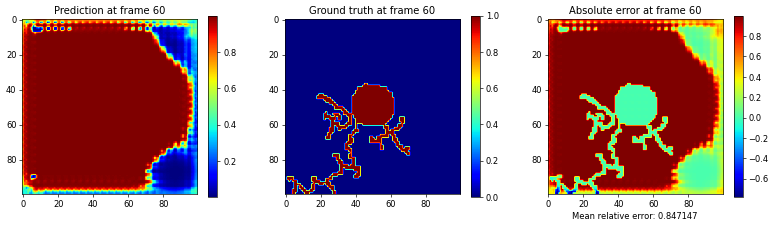

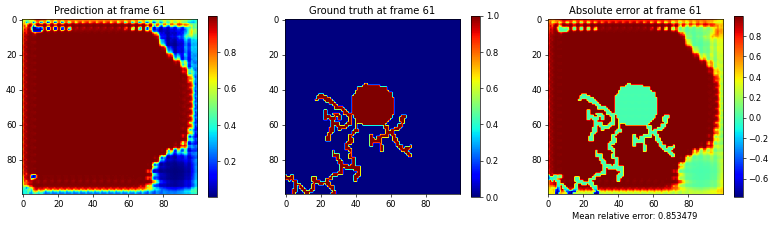

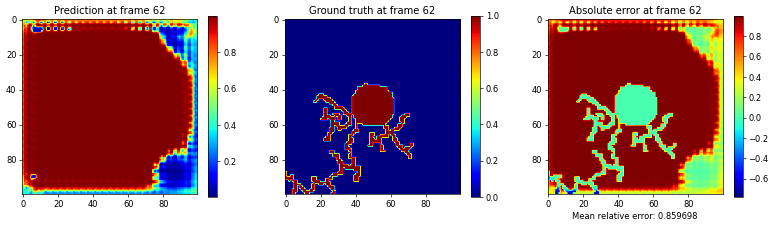

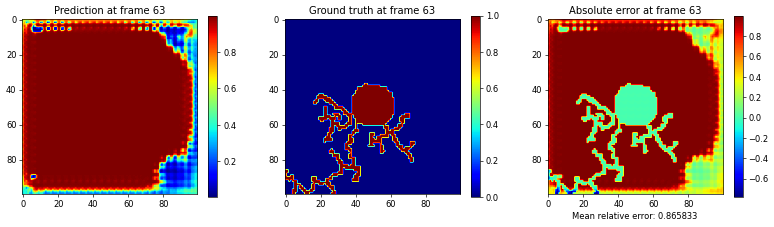

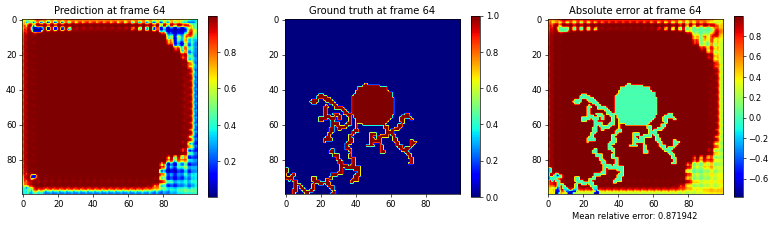

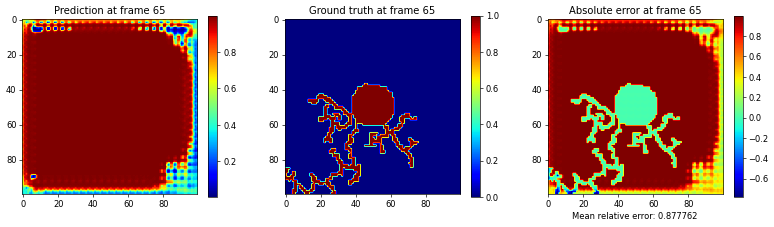

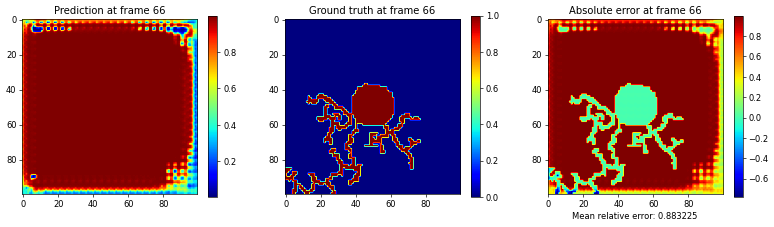

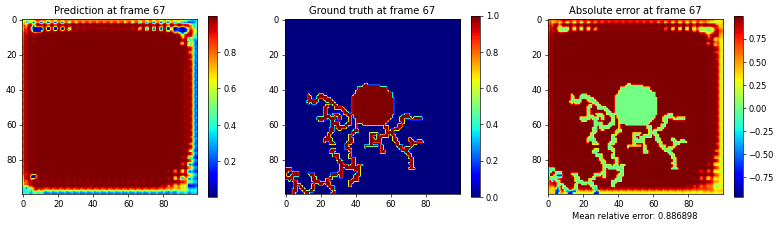

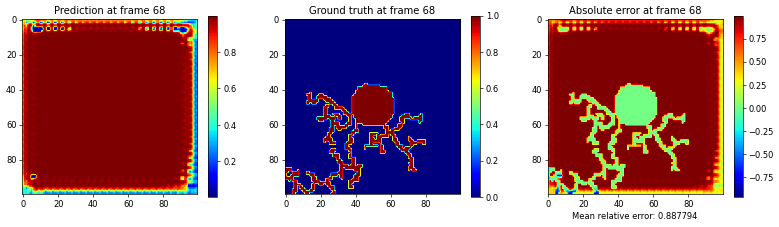

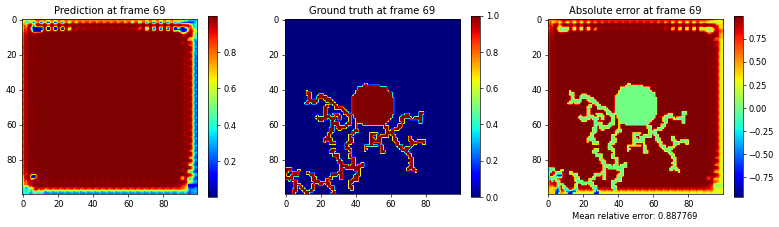

In [25]:
rand_case = np.random.randint((len(val_dataset)))

example_x = x_val[rand_case,...]
example_y = y_val[rand_case,...]

plt.figure(figsize=(16, 4), dpi=60)
plt.subplot(1,3,1)
plt.imshow(example_x[0,:,:,0], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,2)
plt.imshow(example_x[0,:,:,1], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,3)
plt.imshow(example_x[0,:,:,2], cmap='jet')
plt.title('Ground truth at frame 0')
plt.savefig("./Figure/frame_0to3.png")
plt.show()

frames = []
x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

for i in range(example_x.shape[0]):

    new_prediction = model.predict(x_in)
    frames.append(new_prediction[0,0,:,:,0])
    temp = np.zeros([1,1,100,100,3])

    temp[0,0,:,:,0] = x_in[0,0,:,:,1]
    temp[0,0,:,:,1] = x_in[0,0,:,:,2]
    temp[0,0,:,:,2] = new_prediction[0,0,:,:,0]

    x_in = temp


    mre = np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3])))

    plt.figure(figsize=(16, 4), dpi=60)

    plt.subplot(1,3,1)
    plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Prediction at frame %d'%(i+3))

    plt.subplot(1,3,2)
    plt.imshow(example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Ground truth at frame %d'%(i+3))

    plt.subplot(1,3,3)
    plt.imshow(new_prediction[0,0,:,:,0]-example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Absolute error at frame %d'%(i+3))
    plt.xlabel('Mean relative error: %f'%mre)

    plt.savefig("./Figure/frame_%d.png"%(i+3))
    plt.show()
